In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt
from matplotlib import rc

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime

from dateparser import parse

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
domain = "NZ"
NZ_regions = ["NNI", "WNI", "ENI", "NSI", "WSI", "ESI"]
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
shapes_path = "/home/nicolasf/operational/OISST_indices/data/shapefiles/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 1
nmonths_back = 12 * 3
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
shapes_path = pathlib.Path(shapes_path)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

In [12]:
first_day = parse(f"{nmonths_back} months ago")

In [13]:
first_day = first_day - timedelta(days=first_day.day - 1)

In [14]:
first_day

datetime.datetime(2019, 8, 1, 9, 26, 24, 734373)

## get the years to read 

In [15]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [16]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [17]:
lfiles.sort()

In [18]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2019.v2.nc')

In [19]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/NZ/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [20]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [21]:
dset

<xarray.Dataset>
Dimensions:  (time: 1321, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2022-08-13
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 80, 72), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [22]:
if ndays_agg > 1:

    dset = dset.rolling({'time':ndays_agg}, min_periods=ndays_agg, center=False).mean('time')
    
    dset = dset.isel(time=slice(ndays_agg+1, None))

## get the first and last day from the dataset itself now

In [23]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

### creates a standard calendar including leap years, the dataset will be interpolated on it at the end 

In [24]:
standard_calendar = pd.date_range(start=first_day, end=last_day, freq="D")

### get rid of the 29th of Feb if present 

In [25]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [26]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [27]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [28]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

### repeat the climatology over the time dimension 

In [29]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [30]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 1320, quantile: 5)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 218 219 220 221 222 223 224 225
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2019-01-01 00:00:00 ... 2022-08-13 00:00:00
Data variables:
    average    (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### creates the masks for each NZ regions

In [31]:
l_masks = []

for NZ_region in NZ_regions:

    mask = src.make_mask_from_shape(
        shapes_path.joinpath(f"{NZ_region}_buffered_50km.shp"),
        dset,
        to_crs="EPSG:4326",
        mask_name=NZ_region,
    )

    l_masks.append(mask)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [32]:
NZ_regions_masks = xr.merge(l_masks)

### Now merge the masks with the anomalies, the raw data and the climatology 

In [33]:
anoms = anoms.merge(NZ_regions_masks)

In [34]:
dset = dset.merge(NZ_regions_masks)

In [35]:
clim_repeat = clim_repeat.merge(NZ_regions_masks)

### Now calculates the average anomalies 

##### Note: The regional averages of the anomalies is the same as the regional averages of the raw values minus the regional averages of the climatological average

In [36]:
anoms_ts = []

for NZ_region in NZ_regions:

    anom_ts = (anoms["sst"] * anoms[NZ_region]).mean(["lat", "lon"])

    anom_ts.name = f"SST_anomalies_{NZ_region}"

    anoms_ts.append(anom_ts)

In [37]:
anoms_ts = xr.merge(anoms_ts)

### Now interpolate over the standard calendar 

In [38]:
anoms_ts = anoms_ts.interp_calendar(standard_calendar)

### casts to a pandas dataframe 

In [39]:
anoms_ts = anoms_ts.to_pandas()

In [40]:
anoms_ts.head()

,dayofyear,SST_anomalies_NNI,SST_anomalies_WNI,SST_anomalies_ENI,SST_anomalies_NSI,SST_anomalies_WSI,SST_anomalies_ESI
time,,,,,,,
2019-01-01,1.0,1.266799,1.486149,1.977668,1.896046,1.354440,2.343809
2019-01-02,2.0,1.248553,1.538745,2.244822,1.954314,1.170829,2.275302
2019-01-03,3.0,1.164060,1.573617,2.103629,1.856534,0.998959,2.082582
2019-01-04,4.0,0.939356,1.491371,1.801225,1.685812,0.950975,1.954536
2019-01-05,5.0,0.893060,1.331864,1.567888,1.505803,0.823160,2.019411


In [41]:
anoms_ts = anoms_ts.drop("dayofyear", axis=1)

In [42]:
anoms_ts.columns = NZ_regions

In [43]:
anoms_ts.head()

,NNI,WNI,ENI,NSI,WSI,ESI
time,,,,,,
2019-01-01,1.266799,1.486149,1.977668,1.896046,1.354440,2.343809
2019-01-02,1.248553,1.538745,2.244822,1.954314,1.170829,2.275302
2019-01-03,1.164060,1.573617,2.103629,1.856534,0.998959,2.082582
2019-01-04,0.939356,1.491371,1.801225,1.685812,0.950975,1.954536
2019-01-05,0.893060,1.331864,1.567888,1.505803,0.823160,2.019411


### Plot the time-series 

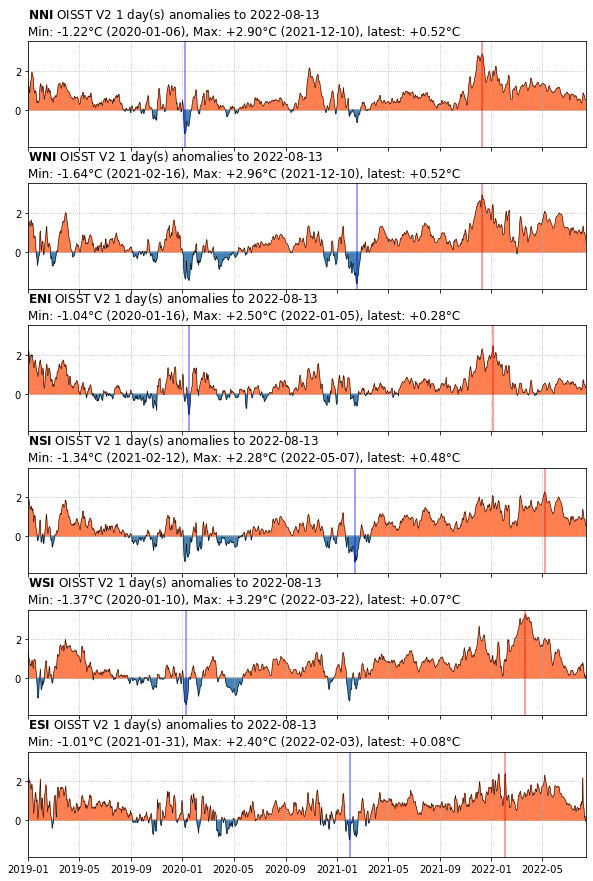

In [44]:
f, axes = plt.subplots(
    nrows=len(NZ_regions), figsize=(10, 15), sharex=True, sharey=True
)

plt.subplots_adjust(hspace=0.35)

for i, NZ_region in enumerate(NZ_regions):

    ax = axes[i]

    df = anoms_ts.loc[:, NZ_region]

    ax.fill_between(
        df.index, 0, df.values, df.values > 0, interpolate=True, color="coral"
    )
    ax.fill_between(
        df.index, 0, df.values, df.values <= 0, interpolate=True, color="steelblue"
    )

    ax.plot(df.index, df.values, color="k", lw=0.5)

    ax.grid(ls=":")

    title = r"$\bf{" + NZ_region + "}$" + f" OISST V2 {ndays_agg} day(s) anomalies to {last_day:%Y-%m-%d}\nMin: {df.min():+4.2f}°C ({df.idxmin():%Y-%m-%d}), Max: {df.max():+4.2f}°C ({df.idxmax():%Y-%m-%d}), latest: {df.iloc[-1]:+4.2f}°C"
        
    ax.set_title(title, loc="left")

    ax.axhline(0, color="0.8", zorder=-1)

    ax.axvline(df.idxmin(), color="b", alpha=0.5)
    ax.axvline(df.idxmax(), color="r", alpha=0.5)

    ax.set_xlim(first_day, last_day)

In [45]:
f.savefig(
    fig_path.joinpath(f"prototype_NZ_coastal_indices_{ndays_agg}days_agg_to_{last_day:%Y%m%d}.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

In [46]:
anoms_ts.tail()

,NNI,WNI,ENI,NSI,WSI,ESI
time,,,,,,
2022-08-09,0.734047,1.010738,0.510967,0.821597,0.055296,0.134158
2022-08-10,0.592380,0.958522,0.445011,0.851406,0.178604,0.215631
2022-08-11,0.544325,0.769641,0.356209,0.617961,0.093740,0.137422
2022-08-12,0.535156,0.730794,0.380686,0.634221,-0.019682,-0.051105
2022-08-13,0.519226,0.521401,0.278315,0.480271,0.065536,0.083127


In [47]:
dset.close()